<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/MLP/HyperMixer/hypermixer%20model%20on%2065_bands%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select the best

def str_to_bool(x):
    return True if x == "True" else False

use_pearson_corr = "False"  #@param ["True", "False"]
add_pos_embedding = "False"  #@param ["True", "False"]
patch_method = "extract"    #@param ["extract", "conv"]

H, W, B = 512, 512, 65               # height,width and band of image
P_S = 9                             #@param [3, 9, 15, 21]                         
patch_size = 3                      # Size of the patches to be extract from the input images
# valid patch size is that number which is divisible by 3 i.e. 3,6,9,12

train_percent = 75          #@param [75, 80, 90]
epoch = 300               #@param [100, 200, 300, 400]

LR_START = 3e-3
LR_MAX = 6e-3 
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
num_patches = (P_S//patch_size)**2

projection_dim = "512"       #@param [64, 128, 256, 512, 1024, 2048]
hidden_dim = "256"            #@param [128, 256, 512, 1024]
dropout_ratio = 0.0         #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]
drop_path = 0.0             #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]

use_pearson_corr = str_to_bool(use_pearson_corr)
add_pos_embedding = str_to_bool(add_pos_embedding)

P_S = int(P_S)
train_percent = int(train_percent)
epoch = int(epoch)
hidden_dim = int(hidden_dim) 
channels_mlp_dim = hidden_dim
projection_dim = int(projection_dim)
dropout_ratio = float(dropout_ratio)
drop_path = int(drop_path)


print("Number of patches per P_S: ", num_patches)
print("Size of each patch for MLP Mixture: ", patch_size)

Number of patches per P_S:  9
Size of each patch for MLP Mixture:  3


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 17.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc
import pickle

import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input,Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate,LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling1D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, Layer, MaxPool2D, UpSampling2D, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral
from imgaug import augmenters as iaa
import imgaug as ia
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

AUTO = tf.data.AUTOTUNE
np.random.seed(1337)          # to get reproducible results
if use_pearson_corr:
    folder_path = "/content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/With Pearson correlation/"
else:
    folder_path = "/content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/"

try:
    os.mkdir(folder_path)
except:
    pass

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

x, y = mat_x.reshape(H,W,B), mat_y.reshape(H,W)
x = x.astype('float16')

# Normalizing the data between 0,1
for i in range(B):
    band_min = x[:,:,i].min()
    band_max = x[:,:,i].max()
    band_range = band_max - band_min
    x[:,:,i] = (x[:,:,i] - band_min)/band_range

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')

X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1

print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape)
print()
print(f"{len(Y)*100/mat_y.shape[0]}% of data is labeled with {num_classes} classes")

shape of mat_x:  (512, 512, 65)
shape of mat_y:  (512, 512)

minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (512, 512, 65)
shape of y:  (512, 512)

shape of padded_x:  (520, 520, 65)

10525.9765625% of data is labeled with 8 classes


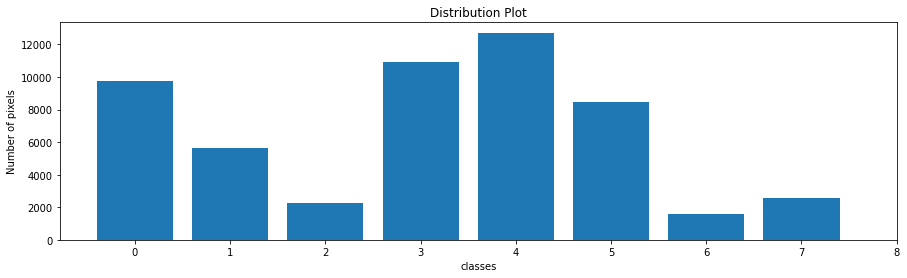

In [ ]:
class_labels, value_counts = np.unique(mat_y, return_counts = True)
plt.figure(figsize = (15,4))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train, x_test,y_train,y_test = tf.cast(np.array(x_train), tf.float32), tf.cast(np.array(x_test), tf.float32), np.array(y_train), np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (40419, 9, 9, 65) 
x_test: (13474, 9, 9, 65) 
y_train: (40419,) 
y_test: (13474,)


### Prediction and performance measure functions

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        try:
            os.mkdir(folder_path + "Results/")
        except:
            pass
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)

    try:
        os.mkdir(folder_path + "Results/" )
    except:
        pass

    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure" + ".png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S)+ " Performance Measure" + ".png"
        fig.savefig(path)

### Building the classes and function for model

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S
    
    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))
    
        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)
    
        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
class Patches(layers.Layer):
    def __init__(self, hidden_dim = 256, patch_size = 3, patch_method='extract', **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.patch_method = patch_method.lower()

    def call(self, images):
        if self.patch_method == "conv":
            x = Conv2D(self.hidden_dim, patch_size, patch_size)(images)              # shape(B, 3, 3, 256)
            patches = Reshape([-1, x.shape[-1]])(x)                                   # shape(B, 9, 256)
            return patches
        else:
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1], padding="VALID",)
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "hidden_dim": self.hidden_dim,
            "patch_method": self.patch_method
        })
        return config

In [ ]:
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim, **kwargs):
#         super(PatchEncoder, self).__init__(**kwargs)
#         self.num_patches = num_patches
#         self.projection_dim = projection_dim
#         self.projection = Dense(projection_dim)
#         self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

#     def call(self, patch,**kwargs):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)    # (9, 512)
#         return encoded

#     def get_config(self, **kwargs):
#         config = super().get_config()
#         config.update({
#             "num_patches": self.num_patches,
#             "projection_dim": self.projection_dim,
#         })
#         return config

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)

    def call(self, patch,**kwargs):
        shape = tf.shape(patch)
        positions = tf.range(start=0, limit=shape[-2], delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=shape[-2])
        encoded = patch + position_embedding(positions)    # (9, 512)
        return encoded

In [ ]:
class Drop_Path(layers.Layer):
    def __init__(self, drop_prob = 0.0, training = False, **kwargs):
        super(Drop_Path, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.training = training
    def call(self, x, **kwargs):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 -  self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        random_tensor.floor_()  # binarize
        output = tf.divide(x, keep_prob) * random_tensor
        return output
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "drop_prob": self.drop_prob,
            "training": self.training,
        })
        return config

In [ ]:
class MLP(layers.Layer):
    def __init__(self, in_features, out_features, drop = 0.0, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.drop = drop
        self.mlp_1 = Dense(in_features, activation = activations.gelu, use_bias = False)
        self.drop_1 = Dropout(drop)
        self.mlp_2 = Dense(out_features, activation = activations.gelu, use_bias = False)
        self.drop_2 = Dropout(drop)

    def call(self, x):
        x = self.drop_1(self.mlp_1(x))
        x = self.drop_2(self.mlp_2(x))
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "in_features": self.in_features,
            "out_features": self.out_features,
            "drop": self.drop,
        })
        return config

In [ ]:
class HyperMixer(layers.Layer):
    def __init__(self, num_patches, dim, hidden_dim, add_pos_embedding = False, dropout_ratio = 0.0, **kwargs):
        super(HyperMixer, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.add_pos_embedding = add_pos_embedding
        self.dropout_ratio = dropout_ratio
        # hidden_dim
        self.mlp_1 = MLP(hidden_dim, dim, drop = dropout_ratio)
        self.drop = Dropout(dropout_ratio)
    def call(self, x, **kwargs):
        # mlp_1 = Dense(hidden_dim, activation=activations.gelu, use_bias=False)                              
        # drop = Dropout(dropout_ratio)
        # act = activations.gelu()

        if self.add_pos_embedding:
            weights = PositionEmbedding()(x)                      # (9, 512)
        else:
            weights = x + x
        weights = self.mlp_1(weights)                                                    # (9, 512)
        x = self.drop(activations.gelu(tf.transpose(weights, (0,2,1)) @ x))                                  # (512, 512)
        x = self.drop(weights@x)                                                       # (9, 512)
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "dim": self.dim,
            "hidden_dim": self.hidden_dim,
            "add_pos_embedding": self.add_pos_embedding,
            "dropout_ratio": self.dropout_ratio,
        })
        return config

In [ ]:
class HyperMixerBlock(layers.Layer):
    def __init__(self, num_patches, dim, mlp_ratio = (0.5, 4), add_pos_embedding = False, dropout_ratio = 0.0, drop_path = 0.0, **kwargs):
        super(HyperMixerBlock, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.mlp_ratio = mlp_ratio
        tokens_dim, channels_dim = [int(i*self.dim) for i in self.mlp_ratio]
        self.add_pos_embedding = add_pos_embedding
        self.dropout_ratio = dropout_ratio
        self.drop_path = drop_path

        self.norm1 = LayerNormalization(axis = -1, epsilon=1e-6)
        # self.norm1 = BatchNormalization()
        self.norm2 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.mlp_channels = MLP(channels_dim, dim, drop = dropout_ratio)
        # tokens_dim = 256
        # channels_dim = 2048
        self.mlp_tokens = HyperMixer(num_patches = self.num_patches, dim=self.dim, hidden_dim=tokens_dim, add_pos_embedding = self.add_pos_embedding , dropout_ratio=self.dropout_ratio)   # (9, 512)
        # self.mlp_channels = Dense(2048, activation = activations.gelu, use_bias=False)
        self.DropPath = Drop_Path(drop_prob = self.drop_path, training = False)
        # self.mlp_1 = Dense(hidden_dim, activation=activations.gelu, use_bias=False)
        # self.drop = Dropout(dropout_ratio)
    def call(self, x, **kwargs):
        x = self.norm1(x)                                                       # (9, 512)  
        x = x + self.DropPath(self.mlp_tokens(x))                               # (9, 512)
        x = x + self.DropPath(self.mlp_channels(self.norm2(x)))                 # (9, 512)
        return x
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "dim": self.dim,
            # "mlp_ratio": self.mlp_ratio,
            "add_pos_embedding": self.add_pos_embedding,
            "dropout_ratio": self.dropout_ratio,
            "drop_path": self.drop_path
        })
        return config

In [ ]:
def HyperMixer_classifier(input_shape = (P_S, P_S, B), classes = 13, use_pearson_corr = False, num_patches = 9, projection_dim = 2048, hidden_dim = 512, 
                          add_pos_embedding = True, dropout_ratio = 0.0, drop_path = 0.0):
    add_pos_embedding = False
    inputs = layers.Input(shape=input_shape)                                                # shape = (9,9,372)
    # b = inputs.shape[0]
    # Create patches.
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)                                        # shape = (9,9,372)
    else:
        x0 = inputs
    patches = Patches(hidden_dim=projection_dim,patch_size=patch_size)(x0)              # shape = 9, 3348 ----> 9 patches each shape 3*3*372 = 3348
    
    patches = Dense(hidden_dim)(patches)                  # (9, 512)
    x = HyperMixerBlock(num_patches = num_patches, dim = hidden_dim, mlp_ratio = (0.5, 4), add_pos_embedding = add_pos_embedding, dropout_ratio = dropout_ratio,
                        drop_path = dropout_ratio)(patches)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax", dtype="float32")(x)
    model = Model(inputs = inputs, outputs = outputs, name = "Hyper_Mixer")
    return model

In [ ]:
model = HyperMixer_classifier(input_shape = (P_S, P_S, B), classes = num_classes, use_pearson_corr = use_pearson_corr, num_patches = num_patches, projection_dim = projection_dim, 
                              hidden_dim = hidden_dim, add_pos_embedding = add_pos_embedding, dropout_ratio = dropout_ratio, drop_path = drop_path)

In [ ]:
model.summary()

Model: "Hyper_Mixer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 65)]        0         
                                                                 
 patches (Patches)           (None, None, 585)         0         
                                                                 
 dense (Dense)               (None, None, 256)         150016    
                                                                 
 hyper_mixer_block (HyperMix  (None, None, 256)        590848    
 erBlock)                                                        
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_5 (Dense)             (None, 8)                 

In [ ]:
# def mlp_block(x, hidden_dim, dropout_ratio = 0.1):
#     y = Dense(hidden_dim)(x)
#     y = tf.nn.gelu(y)
#     y = Dropout(dropout_ratio)(y)
#     return Dense(x.shape[-1])(y)

# # hidden_dim = mlp_dim = 128, 256

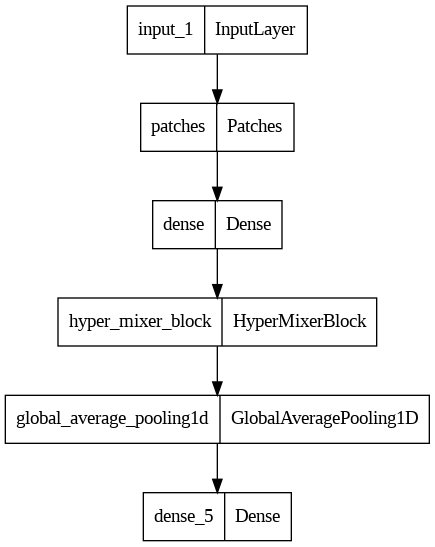

In [ ]:
plot_model(model)

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


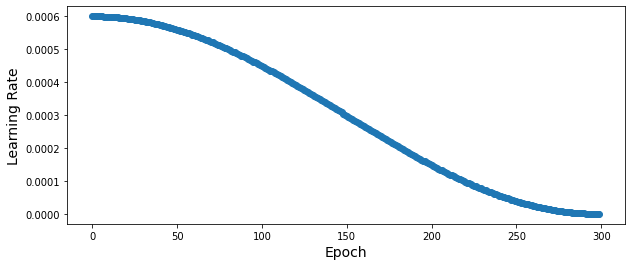

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4 
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint, lr_callback]
model.compile(optimizer=optimizers.Adam(0.000003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_dataset, validation_data = (test_dataset), validation_freq = 1, batch_size = 32, callbacks=callbacks_list, shuffle = False, epochs=epochs)
start_time = time.time()
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), validation_freq = 1, batch_size = BATCH_SIZE, callbacks=callbacks_list, shuffle = False, 
                    epochs=epoch, use_multiprocessing=True)
end_time = time.time()
tt = end_time - start_time
print("total training time: ", tt)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/300
316/316 [==============================] - ETA: 0s - loss: 8.9595 - accuracy: 0.5864
Epoch 1: val_accuracy improved from -inf to 0.74670, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 29s 57ms/step - loss: 8.9595 - accuracy: 0.5864 - val_loss: 0.8038 - val_accuracy: 0.7467 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999834433585453.
Epoch 2/300
315/316 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.7609
Epoch 2: val_accuracy improved from 0.74670 to 0.77178, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 7s 24ms/step - loss: 0.7051 - accuracy: 0.7610 - val_loss: 0.6184 - val_accuracy: 0.7718 - lr: 5.9998e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005999337752619684.
Epoch 3/300
316/316 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.7863
Epoch 3: val_accuracy improved from 0.77178 to 0.80815, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.6080 - accuracy: 0.7863 - val_loss: 0.5326 - val_accuracy: 0.8081 - lr: 5.9993e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005998510011934292.
Epoch 4/300
315/316 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.8020
Epoch 4: val_accuracy did not improve from 0.80815
316/316 [==============================] - 5s 17ms/step - loss: 0.5503 - accuracy: 0.8020 - val_loss: 0.4992 - val_accuracy: 0.8017 - lr: 5.9985e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005997351302908542.
Epoch 5/300
314/316 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.8130
Epoch 5: val_accuracy improved from 0.80815 to 0.85290, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.5148 - accuracy: 0.8132 - val_loss: 0.4610 - val_accuracy: 0.8529 - lr: 5.9974e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005995861753459288.
Epoch 6/300
316/316 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.8183
Epoch 6: val_accuracy improved from 0.85290 to 0.86144, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 28ms/step - loss: 0.4866 - accuracy: 0.8183 - val_loss: 0.4146 - val_accuracy: 0.8614 - lr: 5.9959e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0005994041528026842.
Epoch 7/300
316/316 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8322
Epoch 7: val_accuracy improved from 0.86144 to 0.86849, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 24ms/step - loss: 0.4557 - accuracy: 0.8322 - val_loss: 0.3975 - val_accuracy: 0.8685 - lr: 5.9940e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0005991890827556831.
Epoch 8/300
314/316 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8328
Epoch 8: val_accuracy did not improve from 0.86849
316/316 [==============================] - 7s 21ms/step - loss: 0.4477 - accuracy: 0.8329 - val_loss: 0.4445 - val_accuracy: 0.8287 - lr: 5.9919e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0005989409889478.
Epoch 9/300
315/316 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8365
Epoch 9: val_accuracy did not improve from 0.86849
316/316 [==============================] - 5s 17ms/step - loss: 0.4305 - accuracy: 0.8365 - val_loss: 0.4507 - val_accuracy: 0.8426 - lr: 5.9894e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0005986598987676014.
Epoch 10/300
314/31

316/316 [==============================] - 11s 34ms/step - loss: 0.3863 - accuracy: 0.8550 - val_loss: 0.2912 - val_accuracy: 0.9129 - lr: 5.9676e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0005962824261382637.
Epoch 16/300
314/316 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8451
Epoch 16: val_accuracy did not improve from 0.91287
316/316 [==============================] - 6s 20ms/step - loss: 0.4011 - accuracy: 0.8450 - val_loss: 0.3894 - val_accuracy: 0.8586 - lr: 5.9628e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0005957714337335819.
Epoch 17/300
315/316 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8572
Epoch 17: val_accuracy did not improve from 0.91287
316/316 [==============================] - 6s 18ms/step - loss: 0.3731 - accuracy: 0.8573 - val_loss: 0.4128 - val_accuracy: 0.8661 - lr: 5.9577e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0005952277948628305.
Epoch 18/

316/316 [==============================] - 9s 28ms/step - loss: 0.3518 - accuracy: 0.8686 - val_loss: 0.2437 - val_accuracy: 0.9230 - lr: 5.9523e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0005946515695415714.
Epoch 19/300
313/316 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8664
Epoch 19: val_accuracy did not improve from 0.92304
316/316 [==============================] - 6s 18ms/step - loss: 0.3625 - accuracy: 0.8665 - val_loss: 0.2661 - val_accuracy: 0.9000 - lr: 5.9465e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0005940428213827801.
Epoch 20/300
316/316 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8745
Epoch 20: val_accuracy did not improve from 0.92304
316/316 [==============================] - 6s 20ms/step - loss: 0.3347 - accuracy: 0.8745 - val_loss: 0.4642 - val_accuracy: 0.7941 - lr: 5.9404e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.000593401617589824.
Epoch 21/30

316/316 [==============================] - 9s 28ms/step - loss: 0.3294 - accuracy: 0.8786 - val_loss: 0.2193 - val_accuracy: 0.9242 - lr: 5.9273e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.000592022129821934.
Epoch 23/300
314/316 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.8910
Epoch 23: val_accuracy did not improve from 0.92422
316/316 [==============================] - 6s 18ms/step - loss: 0.2977 - accuracy: 0.8910 - val_loss: 0.3376 - val_accuracy: 0.8391 - lr: 5.9202e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0005912839981369443.
Epoch 24/300
316/316 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8970
Epoch 24: val_accuracy improved from 0.92422 to 0.93610, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 9s 27ms/step - loss: 0.2780 - accuracy: 0.8970 - val_loss: 0.1924 - val_accuracy: 0.9361 - lr: 5.9128e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0005905137153808655.
Epoch 25/300
313/316 [============================>.] - ETA: 0s - loss: 0.2810 - accuracy: 0.8953
Epoch 25: val_accuracy did not improve from 0.93610
316/316 [==============================] - 6s 18ms/step - loss: 0.2805 - accuracy: 0.8954 - val_loss: 0.2521 - val_accuracy: 0.8838 - lr: 5.9051e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005897113665898402.
Epoch 26/300
315/316 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.8959
Epoch 26: val_accuracy did not improve from 0.93610
316/316 [==============================] - 6s 20ms/step - loss: 0.2872 - accuracy: 0.8960 - val_loss: 0.2244 - val_accuracy: 0.9184 - lr: 5.8971e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0005888770403399724.
Epoch 27/3

316/316 [==============================] - 8s 25ms/step - loss: 0.2410 - accuracy: 0.9115 - val_loss: 0.1427 - val_accuracy: 0.9518 - lr: 5.8888e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0005880108287375503.
Epoch 28/300
314/316 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8996
Epoch 28: val_accuracy did not improve from 0.95183
316/316 [==============================] - 7s 22ms/step - loss: 0.2742 - accuracy: 0.8998 - val_loss: 0.1659 - val_accuracy: 0.9409 - lr: 5.8801e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.000587112827408878.
Epoch 29/300
314/316 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9066
Epoch 29: val_accuracy did not improve from 0.95183
316/316 [==============================] - 5s 17ms/step - loss: 0.2659 - accuracy: 0.9067 - val_loss: 0.1634 - val_accuracy: 0.9452 - lr: 5.8711e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0005861831354897182.
Epoch 30/30

316/316 [==============================] - 8s 25ms/step - loss: 0.1651 - accuracy: 0.9371 - val_loss: 0.1241 - val_accuracy: 0.9538 - lr: 5.7260e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0005712647183163642.
Epoch 43/300
314/316 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9253
Epoch 43: val_accuracy improved from 0.95384 to 0.96616, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 25ms/step - loss: 0.2136 - accuracy: 0.9254 - val_loss: 0.0979 - val_accuracy: 0.9662 - lr: 5.7126e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0005699037042616427.
Epoch 44/300
314/316 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9257
Epoch 44: val_accuracy did not improve from 0.96616
316/316 [==============================] - 6s 18ms/step - loss: 0.2122 - accuracy: 0.9258 - val_loss: 0.1265 - val_accuracy: 0.9545 - lr: 5.6990e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0005685128994349479.
Epoch 45/300
315/316 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9363
Epoch 45: val_accuracy did not improve from 0.96616
316/316 [==============================] - 5s 17ms/step - loss: 0.1685 - accuracy: 0.9363 - val_loss: 0.1868 - val_accuracy: 0.9220 - lr: 5.6851e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0005670924573755823.
Epoch 46/3

316/316 [==============================] - 8s 27ms/step - loss: 0.1669 - accuracy: 0.9380 - val_loss: 0.0802 - val_accuracy: 0.9743 - lr: 5.6112e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0005595512905130442.
Epoch 51/300
313/316 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9461
Epoch 51: val_accuracy did not improve from 0.97432
316/316 [==============================] - 5s 17ms/step - loss: 0.1487 - accuracy: 0.9460 - val_loss: 0.1412 - val_accuracy: 0.9437 - lr: 5.5955e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0005579564313737454.
Epoch 52/300
316/316 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9406
Epoch 52: val_accuracy did not improve from 0.97432
316/316 [==============================] - 6s 19ms/step - loss: 0.1599 - accuracy: 0.9406 - val_loss: 0.1228 - val_accuracy: 0.9571 - lr: 5.5796e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0005563331003937192.
Epoch 53/3

316/316 [==============================] - 9s 28ms/step - loss: 0.1200 - accuracy: 0.9541 - val_loss: 0.0666 - val_accuracy: 0.9751 - lr: 5.5468e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.000553001742871924.
Epoch 55/300
316/316 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9456
Epoch 55: val_accuracy improved from 0.97506 to 0.97618, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 7s 24ms/step - loss: 0.1549 - accuracy: 0.9456 - val_loss: 0.0719 - val_accuracy: 0.9762 - lr: 5.5300e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0005512940840987303.
Epoch 56/300
313/316 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9508
Epoch 56: val_accuracy did not improve from 0.97618
316/316 [==============================] - 7s 22ms/step - loss: 0.1336 - accuracy: 0.9508 - val_loss: 0.0825 - val_accuracy: 0.9710 - lr: 5.5129e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000549558688981359.
Epoch 57/300
314/316 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9503
Epoch 57: val_accuracy did not improve from 0.97618
316/316 [==============================] - 6s 18ms/step - loss: 0.1365 - accuracy: 0.9503 - val_loss: 0.1086 - val_accuracy: 0.9598 - lr: 5.4956e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.000547795749100505.
Epoch 58/300

316/316 [==============================] - 9s 28ms/step - loss: 0.1138 - accuracy: 0.9584 - val_loss: 0.0506 - val_accuracy: 0.9832 - lr: 5.4047e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0005385747952140647.
Epoch 63/300
316/316 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9598
Epoch 63: val_accuracy did not improve from 0.98323
316/316 [==============================] - 6s 20ms/step - loss: 0.1113 - accuracy: 0.9598 - val_loss: 0.1664 - val_accuracy: 0.9317 - lr: 5.3857e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0005366507787109227.
Epoch 64/300
314/316 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9553
Epoch 64: val_accuracy did not improve from 0.98323
316/316 [==============================] - 7s 21ms/step - loss: 0.1254 - accuracy: 0.9551 - val_loss: 0.1821 - val_accuracy: 0.9460 - lr: 5.3665e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0005347006424260771.
Epoch 65/3

316/316 [==============================] - 9s 28ms/step - loss: 0.0964 - accuracy: 0.9652 - val_loss: 0.0355 - val_accuracy: 0.9886 - lr: 4.9299e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0004905645669706604.
Epoch 85/300
314/316 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9697
Epoch 85: val_accuracy did not improve from 0.98857
316/316 [==============================] - 6s 18ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 0.1204 - val_accuracy: 0.9598 - lr: 4.9056e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0004881198664460812.
Epoch 86/300
315/316 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9719
Epoch 86: val_accuracy did not improve from 0.98857
316/316 [==============================] - 7s 21ms/step - loss: 0.0820 - accuracy: 0.9719 - val_loss: 0.0979 - val_accuracy: 0.9607 - lr: 4.8812e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.00048565440375882707.
Epoch 87/

316/316 [==============================] - 8s 25ms/step - loss: 0.0798 - accuracy: 0.9725 - val_loss: 0.0345 - val_accuracy: 0.9891 - lr: 4.7559e-04

Epoch 92: LearningRateScheduler setting learning rate to 0.00047302526261835444.
Epoch 92/300
314/316 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9732
Epoch 92: val_accuracy did not improve from 0.98909
316/316 [==============================] - 5s 17ms/step - loss: 0.0831 - accuracy: 0.9732 - val_loss: 0.0509 - val_accuracy: 0.9845 - lr: 4.7303e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0004704410207820102.
Epoch 93/300
316/316 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9768
Epoch 93: val_accuracy did not improve from 0.98909
316/316 [==============================] - 6s 19ms/step - loss: 0.0654 - accuracy: 0.9768 - val_loss: 0.0516 - val_accuracy: 0.9826 - lr: 4.7044e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0004678379684569967.
Epoch 94/

316/316 [==============================] - 8s 25ms/step - loss: 0.0489 - accuracy: 0.9824 - val_loss: 0.0296 - val_accuracy: 0.9904 - lr: 4.4361e-04

Epoch 104: LearningRateScheduler setting learning rate to 0.0004408370756875855.
Epoch 104/300
316/316 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9737
Epoch 104: val_accuracy did not improve from 0.99035
316/316 [==============================] - 6s 20ms/step - loss: 0.0897 - accuracy: 0.9737 - val_loss: 0.0789 - val_accuracy: 0.9734 - lr: 4.4084e-04

Epoch 105: LearningRateScheduler setting learning rate to 0.000438046508067459.
Epoch 105/300
314/316 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9864
Epoch 105: val_accuracy did not improve from 0.99035
316/316 [==============================] - 6s 19ms/step - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.0784 - val_accuracy: 0.9697 - lr: 4.3805e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0004352407061835816.
Epoc

316/316 [==============================] - 8s 26ms/step - loss: 0.0531 - accuracy: 0.9816 - val_loss: 0.0221 - val_accuracy: 0.9929 - lr: 4.0346e-04

Epoch 118: LearningRateScheduler setting learning rate to 0.0004004971396706873.
Epoch 118/300
313/316 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9819
Epoch 118: val_accuracy did not improve from 0.99288
316/316 [==============================] - 6s 18ms/step - loss: 0.0504 - accuracy: 0.9819 - val_loss: 0.0687 - val_accuracy: 0.9737 - lr: 4.0050e-04

Epoch 119: LearningRateScheduler setting learning rate to 0.0003975220445195922.
Epoch 119/300
314/316 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9885
Epoch 119: val_accuracy did not improve from 0.99288
316/316 [==============================] - 6s 20ms/step - loss: 0.0323 - accuracy: 0.9885 - val_loss: 0.0246 - val_accuracy: 0.9917 - lr: 3.9752e-04

Epoch 120: LearningRateScheduler setting learning rate to 0.00039453618884378985.
Ep

316/316 [==============================] - 8s 26ms/step - loss: 0.0637 - accuracy: 0.9810 - val_loss: 0.0202 - val_accuracy: 0.9935 - lr: 3.8853e-04

Epoch 123: LearningRateScheduler setting learning rate to 0.0003855173606547723.
Epoch 123/300
314/316 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9865
Epoch 123: val_accuracy did not improve from 0.99354
316/316 [==============================] - 6s 20ms/step - loss: 0.0383 - accuracy: 0.9865 - val_loss: 0.0500 - val_accuracy: 0.9822 - lr: 3.8552e-04

Epoch 124: LearningRateScheduler setting learning rate to 0.0003824917704782321.
Epoch 124/300
315/316 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891
Epoch 124: val_accuracy improved from 0.99354 to 0.99532, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 7s 23ms/step - loss: 0.0327 - accuracy: 0.9891 - val_loss: 0.0149 - val_accuracy: 0.9953 - lr: 3.8249e-04

Epoch 125: LearningRateScheduler setting learning rate to 0.0003794570790592535.
Epoch 125/300
316/316 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9850
Epoch 125: val_accuracy did not improve from 0.99532
316/316 [==============================] - 6s 19ms/step - loss: 0.0424 - accuracy: 0.9850 - val_loss: 0.1177 - val_accuracy: 0.9526 - lr: 3.7946e-04

Epoch 126: LearningRateScheduler setting learning rate to 0.00037641362141565773.
Epoch 126/300
314/316 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9862
Epoch 126: val_accuracy improved from 0.99532 to 0.99540, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 25ms/step - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.0154 - val_accuracy: 0.9954 - lr: 3.7641e-04

Epoch 127: LearningRateScheduler setting learning rate to 0.0003733617335330225.
Epoch 127/300
314/316 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9872
Epoch 127: val_accuracy improved from 0.99540 to 0.99607, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 27ms/step - loss: 0.0370 - accuracy: 0.9873 - val_loss: 0.0140 - val_accuracy: 0.9961 - lr: 3.7336e-04

Epoch 128: LearningRateScheduler setting learning rate to 0.0003703017523275899.
Epoch 128/300
316/316 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9850
Epoch 128: val_accuracy did not improve from 0.99607
316/316 [==============================] - 5s 17ms/step - loss: 0.0426 - accuracy: 0.9850 - val_loss: 0.0575 - val_accuracy: 0.9792 - lr: 3.7030e-04

Epoch 129: LearningRateScheduler setting learning rate to 0.0003672340156090729.
Epoch 129/300
315/316 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9846
Epoch 129: val_accuracy did not improve from 0.99607
316/316 [==============================] - 6s 19ms/step - loss: 0.0504 - accuracy: 0.9847 - val_loss: 0.0366 - val_accuracy: 0.9870 - lr: 3.6723e-04

Epoch 130: LearningRateScheduler setting learning rate to 0.0003641588620433618.
Epo

316/316 [==============================] - 9s 27ms/step - loss: 0.0499 - accuracy: 0.9850 - val_loss: 0.0122 - val_accuracy: 0.9967 - lr: 3.2366e-04

Epoch 144: LearningRateScheduler setting learning rate to 0.0003205193118887331.
Epoch 144/300
315/316 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9971
Epoch 144: val_accuracy improved from 0.99673 to 0.99718, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9972 - lr: 3.2052e-04

Epoch 145: LearningRateScheduler setting learning rate to 0.0003173740126200891.
Epoch 145/300
313/316 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9504
Epoch 145: val_accuracy did not improve from 0.99718
316/316 [==============================] - 6s 18ms/step - loss: 0.1659 - accuracy: 0.9505 - val_loss: 0.0812 - val_accuracy: 0.9685 - lr: 3.1737e-04

Epoch 146: LearningRateScheduler setting learning rate to 0.0003142268008495914.
Epoch 146/300
313/316 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9850
Epoch 146: val_accuracy did not improve from 0.99718
316/316 [==============================] - 6s 19ms/step - loss: 0.0477 - accuracy: 0.9850 - val_loss: 0.0304 - val_accuracy: 0.9902 - lr: 3.1423e-04

Epoch 147: LearningRateScheduler setting learning rate to 0.0003110780240168591.
Epo

316/316 [==============================] - 9s 27ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0069 - val_accuracy: 0.9984 - lr: 2.7644e-04

Epoch 159: LearningRateScheduler setting learning rate to 0.00027329721574402067.
Epoch 159/300
314/316 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9927
Epoch 159: val_accuracy did not improve from 0.99844
316/316 [==============================] - 7s 21ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.0097 - val_accuracy: 0.9965 - lr: 2.7330e-04

Epoch 160: LearningRateScheduler setting learning rate to 0.0002701597363156906.
Epoch 160/300
315/316 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9951
Epoch 160: val_accuracy did not improve from 0.99844
316/316 [==============================] - 6s 19ms/step - loss: 0.0137 - accuracy: 0.9951 - val_loss: 0.0065 - val_accuracy: 0.9984 - lr: 2.7016e-04

Epoch 161: LearningRateScheduler setting learning rate to 0.0002670255566531802.
Ep

316/316 [==============================] - 9s 27ms/step - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.0059 - val_accuracy: 0.9988 - lr: 2.6077e-04

Epoch 164: LearningRateScheduler setting learning rate to 0.0002576462742192873.
Epoch 164/300
316/316 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9916
Epoch 164: val_accuracy did not improve from 0.99881
316/316 [==============================] - 6s 18ms/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0130 - val_accuracy: 0.9961 - lr: 2.5765e-04

Epoch 165: LearningRateScheduler setting learning rate to 0.0002545287494138232.
Epoch 165/300
316/316 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9920
Epoch 165: val_accuracy did not improve from 0.99881
316/316 [==============================] - 6s 19ms/step - loss: 0.0233 - accuracy: 0.9920 - val_loss: 0.0143 - val_accuracy: 0.9955 - lr: 2.5453e-04

Epoch 166: LearningRateScheduler setting learning rate to 0.00025141624997274993.
Ep

316/316 [==============================] - 9s 28ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0050 - val_accuracy: 0.9989 - lr: 1.5926e-04

Epoch 198: LearningRateScheduler setting learning rate to 0.00015648789902356747.
Epoch 198/300
313/316 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 198: val_accuracy improved from 0.99889 to 0.99926, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/65 bands/Without Pearson correlation/Trained models/75% ps_9


316/316 [==============================] - 8s 26ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 0.9993 - lr: 1.5649e-04

Epoch 199: LearningRateScheduler setting learning rate to 0.00015372872241771634.
Epoch 199/300
315/316 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9972
Epoch 199: val_accuracy did not improve from 0.99926
316/316 [==============================] - 7s 22ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0095 - val_accuracy: 0.9965 - lr: 1.5373e-04

Epoch 200: LearningRateScheduler setting learning rate to 0.0001509856990969469.
Epoch 200/300
316/316 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9984
Epoch 200: val_accuracy did not improve from 0.99926
316/316 [==============================] - 6s 20ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0050 - val_accuracy: 0.9988 - lr: 1.5099e-04

Epoch 201: LearningRateScheduler setting learning rate to 0.00014825913188008636.
E

316/316 [==============================] - 8s 25ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0033 - val_accuracy: 0.9996 - lr: 1.2196e-04

Epoch 212: LearningRateScheduler setting learning rate to 0.00011943771713272893.
Epoch 212/300
314/316 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994
Epoch 212: val_accuracy did not improve from 0.99955
316/316 [==============================] - 6s 20ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0105 - val_accuracy: 0.9959 - lr: 1.1944e-04

Epoch 213: LearningRateScheduler setting learning rate to 0.00011693154891386087.
Epoch 213/300
313/316 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9964
Epoch 213: val_accuracy did not improve from 0.99955
316/316 [==============================] - 6s 18ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0063 - val_accuracy: 0.9988 - lr: 1.1693e-04

Epoch 214: LearningRateScheduler setting learning rate to 0.00011444559624117294.


316/316 [==============================] - 8s 25ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9996 - lr: 7.5534e-05

Epoch 232: LearningRateScheduler setting learning rate to 7.345675203360006e-05.
Epoch 232/300
315/316 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9996
Epoch 232: val_accuracy did not improve from 0.99963
316/316 [==============================] - 6s 19ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0024 - val_accuracy: 0.9996 - lr: 7.3457e-05

Epoch 233: LearningRateScheduler setting learning rate to 7.140431797137115e-05.
Epoch 233/300
316/316 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9939
Epoch 233: val_accuracy did not improve from 0.99963
316/316 [==============================] - 5s 17ms/step - loss: 0.0301 - accuracy: 0.9939 - val_loss: 0.0030 - val_accuracy: 0.9993 - lr: 7.1404e-05

Epoch 234: LearningRateScheduler setting learning rate to 6.937712547992065e-05.
Epo

316/316 [==============================] - 7s 24ms/step - loss: 9.2703e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 0.9997 - lr: 6.7375e-05

Epoch 236: LearningRateScheduler setting learning rate to 6.539935757392295e-05.
Epoch 236/300
316/316 [==============================] - ETA: 0s - loss: 8.3898e-04 - accuracy: 0.9999
Epoch 236: val_accuracy did not improve from 0.99970
316/316 [==============================] - 6s 20ms/step - loss: 8.3898e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9997 - lr: 6.5399e-05

Epoch 237: LearningRateScheduler setting learning rate to 6.344922128907727e-05.
Epoch 237/300
313/316 [============================>.] - ETA: 0s - loss: 8.3791e-04 - accuracy: 0.9998
Epoch 237: val_accuracy did not improve from 0.99970
316/316 [==============================] - 6s 17ms/step - loss: 8.3430e-04 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9997 - lr: 6.3449e-05

Epoch 238: LearningRateScheduler setting learning rate to 6.1525

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  742920
Trainable_params:  742920
Non_trainable_params:  0


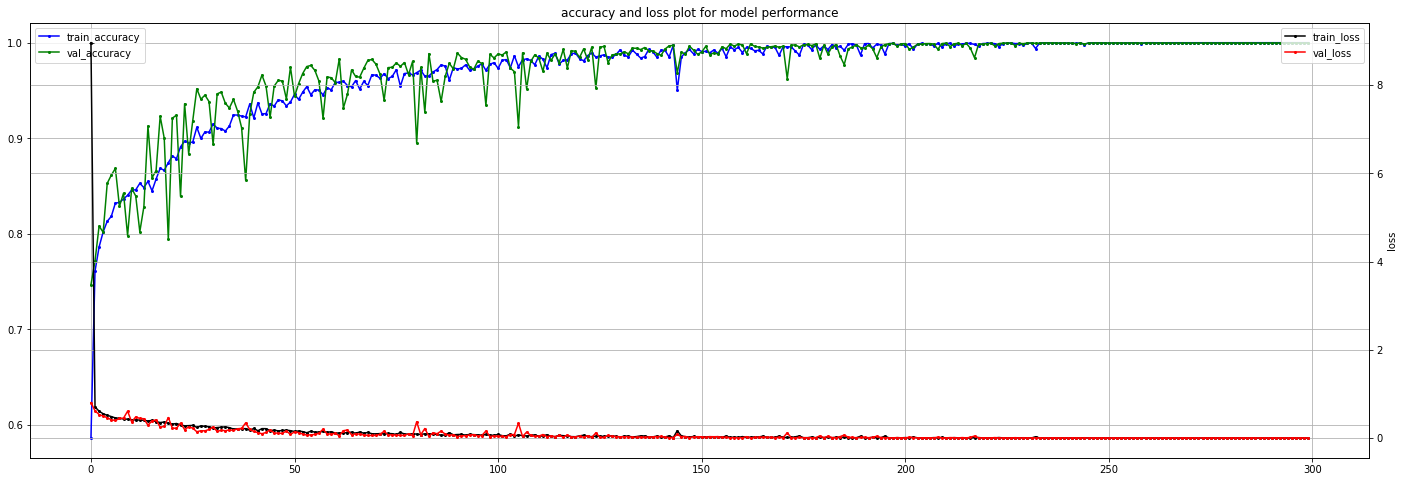

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None)

In [ ]:
y_pred = predict(model, x_test)

422/422 [==============================] - 2s 5ms/step


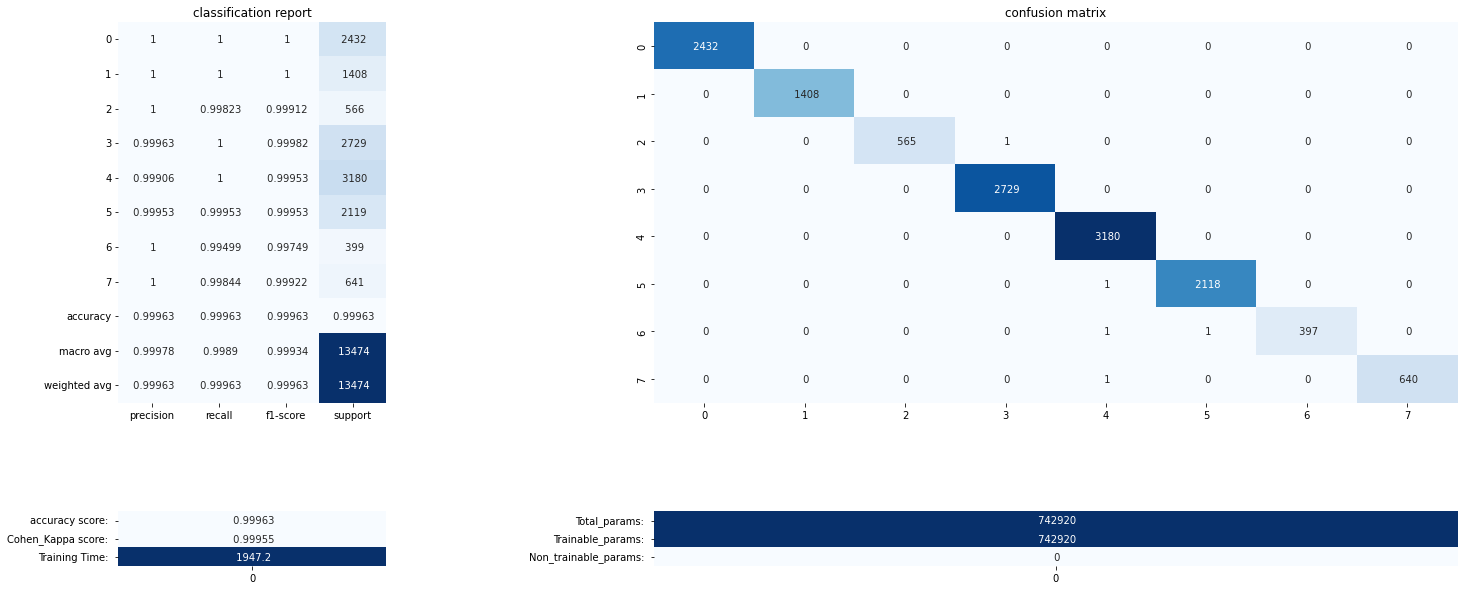

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = folder_path)

In [ ]:
for i in range(10):
    gc.collect()

In [ ]:
if use_pearson_corr:
    filepath1 = folder_path +"Results/ "+ str(train_percent)+"% performance.txt"
else:
    filepath1 = folder_path +"Results/"+ str(train_percent)+"% performance_ps_"+str(P_S)+".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[2432    0    0    0    0    0    0    0]
 [   0 1408    0    0    0    0    0    0]
 [   0    0  565    1    0    0    0    0]
 [   0    0    0 2729    0    0    0    0]
 [   0    0    0    0 3180    0    0    0]
 [   0    0    0    0    1 2118    0    0]
 [   0    0    0    0    1    1  397    0]
 [   0    0    0    0    1    0    0  640]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      1408
           2       1.00      1.00      1.00       566
           3       1.00      1.00      1.00      2729
           4       1.00      1.00      1.00      3180
           5       1.00      1.00      1.00      2119
           6       1.00      0.99      1.00       399
           7       1.00      1.00      1.00       641

    accuracy                           1.00     13474
   macro avg       1.00      1.00      1.00     13474
weighted avg       1.00   

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)
if use_pearson_corr:
    img_path = folder_path +"Results/with_corr_"+str(train_percent)+"%_hyper_mixer_ps"+str(P_S)+".csv"
else:
    img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_hyper_mixer_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(img_path, y_combined, delimiter=",")

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

In [ ]:
y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([12188,  8005,  7800, 44166, 97279, 47713,  9940, 35053]))


In [ ]:
y_hat = y_hat.reshape((H,W))

In [ ]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image" + ".png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

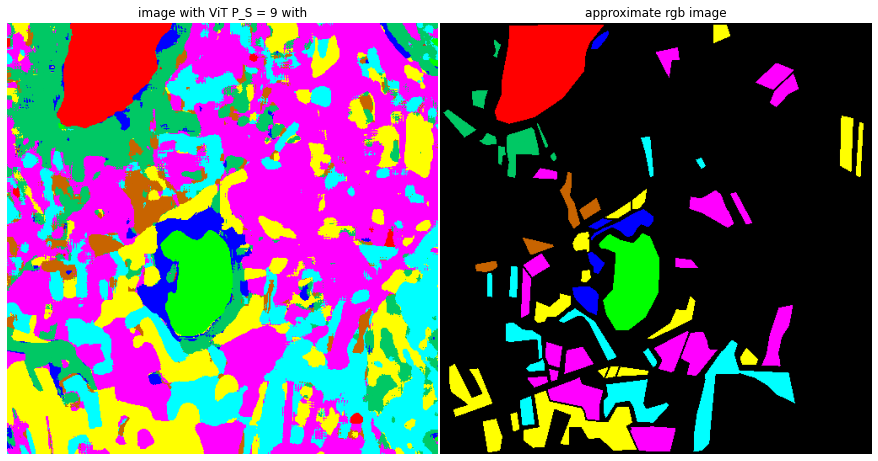

In [ ]:
# img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image with" + str(method) + ".png"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, 12))
img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title("image with ViT P_S = 9 with")
ax1.axis("off")

ax2.imshow(plt.imread("/content/available_image.png"))

ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()